In [3]:
import pandas as pd
import numpy as np
from xml.etree import cElementTree as ElementTree
import xml.etree.ElementTree as et
from tqdm import tqdm
import logging
import re
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import zipcodes
#exec(requests.get('https://raw.githubusercontent.com/ma-ji/npo_classifier/master/API/npoclass.py').text)

#logging.basicConfig(format='%(asctime)s: %(message)s', filename='analysis.log', level=logging.DEBUG)

# Data Cleaning

In [24]:
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 300)
pd.set_option('display.min_rows', 50)
df2016 = pd.read_csv("C:/Users/tenis/OneDrive/Desktop/Data_Projects/Impact_Capital/data/interim/2016_objects.csv")
df2017 = pd.read_csv("C:/Users/tenis/OneDrive/Desktop/Data_Projects/Impact_Capital/data/interim/2017_objects.csv")
df = pd.read_csv("C:/Users/tenis/OneDrive/Desktop/Data_Projects/Impact_Capital/data/interim/form_990_objects_2018_2020.csv")

df = df.append(df2017, ignore_index = True)
df = df.append(df2016, ignore_index = True)

#Fixing Types of Orgs 
df.loc[df['TypeOfOrganizationCorpInd'] != "X", 'TypeOfOrganizationCorpInd'] = 0
df.loc[df['TypeOfOrganizationCorpInd'] == "X", 'TypeOfOrganizationCorpInd'] = 1
df.loc[df['TypeOfOrganizationTrustInd'] != "X", 'TypeOfOrganizationTrustInd'] = 0
df.loc[df['TypeOfOrganizationTrustInd'] == "X", 'TypeOfOrganizationTrustInd'] = 1
df.loc[df['TypeOfOrganizationTrustInd'] != "X", 'TypeOfOrganizationTrustInd'] = 0
df.loc[df['TypeOfOrganizationTrustInd'] == "X", 'TypeOfOrganizationTrustInd'] = 1
df.loc[df['TypeOfOrganizationAssocInd'] != "X", 'TypeOfOrganizationAssocInd'] = 0
df.loc[df['TypeOfOrganizationAssocInd'] == "X", 'TypeOfOrganizationAssocInd'] = 1
df.loc[df['TypeOfOrganizationOtherInd'] != "X", 'TypeOfOrganizationOtherInd'] = 0
df.loc[df['TypeOfOrganizationOtherInd'] == "X", 'TypeOfOrganizationOtherInd'] = 1

#SchoolOperatingInd	OperateHospitalInd	AddressChangeInd	InitialReturnInd	AmendedReturnInd	TerminateOperationsInd
df[['SchoolOperatingInd', 'OperateHospitalInd','AddressChangeInd',
    'InitialReturnInd', 'AmendedReturnInd','FinalReturnInd','TerminateOperationsInd','TotalFunctionExpenses_FundraisingAmt']] =df[['SchoolOperatingInd', 'OperateHospitalInd','AddressChangeInd','InitialReturnInd',
                 'AmendedReturnInd','FinalReturnInd','TerminateOperationsInd', 'TotalFunctionExpenses_FundraisingAmt']].fillna(0)

df.loc[df['SchoolOperatingInd'] == 'false', 'SchoolOperatingInd'] = 0
df.loc[df['OperateHospitalInd'] == 'false', 'OperateHospitalInd'] = 0
df.loc[df['AddressChangeInd'] == 'false', 'AddressChangeInd'] = 0
df.loc[df['InitialReturnInd'] == 'false', 'InitialReturnInd'] = 0
df.loc[df['AmendedReturnInd'] == 'false', 'AmendedReturnInd'] = 0
df.loc[df['FinalReturnInd'] == 'false', 'FinalReturnInd'] = 0
df.loc[df['TerminateOperationsInd'] == 'false', 'TerminateOperationsInd'] = 0

df.loc[df['SchoolOperatingInd'] == '0', 'SchoolOperatingInd'] = 0
df.loc[df['OperateHospitalInd'] == '0', 'OperateHospitalInd'] = 0
df.loc[df['AddressChangeInd'] == '0', 'AddressChangeInd'] = 0
df.loc[df['InitialReturnInd'] == '0', 'InitialReturnInd'] = 0
df.loc[df['AmendedReturnInd'] == '0', 'AmendedReturnInd'] = 0
df.loc[df['FinalReturnInd'] == '0', 'FinalReturnInd'] = 0
df.loc[df['TerminateOperationsInd'] == '0', 'TerminateOperationsInd'] = 0

df.loc[df['SchoolOperatingInd'] != 0, 'SchoolOperatingInd'] = 1
df.loc[df['OperateHospitalInd'] != 0, 'OperateHospitalInd'] = 1
df.loc[df['AddressChangeInd'] != 0, 'AddressChangeInd'] = 1
df.loc[df['InitialReturnInd'] != 0, 'InitialReturnInd'] = 1
df.loc[df['AmendedReturnInd'] != 0, 'AmendedReturnInd'] = 1
df.loc[df['FinalReturnInd'] != 0, 'FinalReturnInd'] = 1
df.loc[df['TerminateOperationsInd'] != 0, 'TerminateOperationsInd'] = 1

#Merging the descriptions 
#The majority of the descriptions are just duplicates, so I'm deleting the ones that are exaclty the same 
#df.ActivityOrMissionDesc= df.ActivityOrMissionDesc.str.lower()
#df.MissionDesc= df.MissionDesc.str.lower()
#df.loc[df['ActivityOrMissionDesc'] ==  df['MissionDesc'], 'MissionDesc'] = ""

df = df.drop(['Unnamed: 0', 'Object_ID', 'MissionDesc', 'schedule0'], axis=1)


df['Ratio_Equity_Revenue'] = df['NetAssetsOrFundBalancesEOYAmt']/df['CYTotalRevenueAmt']

df['Ratio_AdminExp_Exp'] = df['TotalFunctionExpenses_ManagementAndGeneralAmt']/df['CYTotalExpensesAmt']

df['Operating_Margin'] = (df['CYTotalRevenueAmt'] - df['CYTotalExpensesAmt'])/df['CYTotalRevenueAmt']

df['Revenue_Concentration'] = (df['RelatedOrganizationsAmt']/df['CYTotalRevenueAmt'])**2 + (df['GovernmentGrantsAmt']/df['CYTotalRevenueAmt'])**2 \
                               + (df['FederatedCampaignsAmt']/df['CYTotalRevenueAmt'])**2 + (df['MembershipDuesAmt']/df['CYTotalRevenueAmt'])**2 \
                               + (df['FundraisingAmt']/df['CYTotalRevenueAmt'])**2 + (df['NoncashContributionsAmt']/df['CYTotalRevenueAmt'])**2 \
                               + (df['AllOtherContributionsAmt']/df['CYTotalRevenueAmt'])**2 + (df['TotalProgramServiceRevenueAmt']/df['CYTotalRevenueAmt'])**2 \
                               + (df['CYInvestmentIncomeAmt']/df['CYTotalRevenueAmt'])**2 + (df['CYOtherRevenueAmt']/df['CYTotalRevenueAmt'])**2

#Resource Dependence measures 
df['Dependence_Grants'] = df['GovernmentGrantsAmt']/df['CYTotalRevenueAmt']
df['Dependence_Campaigns'] = df['FederatedCampaignsAmt']/df['CYTotalRevenueAmt']
df['Dependence_Memberships'] = df['MembershipDuesAmt']/df['CYTotalRevenueAmt']
df['Dependence_Fundraising'] = df['FundraisingAmt']/df['CYTotalRevenueAmt']
df['Dependence_ProgramServ'] = df['TotalProgramServiceRevenueAmt']/df['CYTotalRevenueAmt']
df['Dependence_Invest'] = df['CYInvestmentIncomeAmt']/df['CYTotalRevenueAmt']

#Dependent Variable 
df['Ratio_ProgramExp_Rev'] = df['TotalFunctionExpenses_ProgramServicesAmt']/df['CYTotalRevenueAmt']
df['Ratio_ProgramExp_Totalexp'] = df['TotalFunctionExpenses_ProgramServicesAmt']/df['CYTotalExpensesAmt']



df['BusinessName'].fillna("none", inplace = True) 
df['ActivityOrMissionDesc'].fillna("none", inplace = True)
df['name_mission'] = df['BusinessName'] + ". " + df['ActivityOrMissionDesc']
df2015 = df[df['TaxYr'] == 2015]
df2015["FormationYr"].fillna(2014, inplace = True)

#Adding BERT data 
BERT = pd.read_csv("C:/Users/tenis/OneDrive/Desktop/Data_Projects/Impact_Capital/data/raw/BERT_classifications2015.csv")
df2015BERT = pd.concat([df2015.reset_index(drop=True), BERT], axis=1, ignore_index=False)
print("Number of nonprofits: ", len(df2015BERT))

df2015BERT = df2015BERT.drop(['Unnamed: 0'], axis=1)

#removing duplicates based on EIN. I need to go back and grab the timestamp, so that I remove the earlier submitted returns
df2015BERT = df2015BERT.drop_duplicates(subset="EIN")
print("Number of nonprofits: ", len(df2015BERT))


Number of nonprofits:  233520
Number of nonprofits:  231523


# Contextual County Information 

In [25]:
test = zipcodes.matching('70661')
test
df2015BERT['ZIPCd']  = df2015BERT['ZIPCd'].fillna(0)
df2015BERT['ZIPCd'] = df2015BERT['ZIPCd'].astype('int64')
df2015BERT['ZIPCd'] = df2015BERT['ZIPCd'].astype(str)
#df2015BERT.info()
df2015BERT['ZIPCd'][0]

'6354'

In [29]:
for i in df2015BERT.index:
    if len(df2015BERT.at[i,'ZIPCd']) == 4:
        df2015BERT.at[i,'ZIPCd'] = "0" + df2015BERT.at[i,'ZIPCd']
    elif len(df2015BERT.at[i,'ZIPCd']) == 8:
        df2015BERT.at[i,'ZIPCd'] = "0" + df2015BERT.at[i,'ZIPCd']

In [38]:
for i in df2015BERT.index:
    if len(df2015BERT.at[i,'ZIPCd']) == 9:
        zipcodeplus4 = df2015BERT['ZIPCd'][i]
        zipcode = zipcodeplus4[:-4]
        df2015BERT.at[i,'ZIPCd'] = zipcode

In [37]:
test = df2015BERT['ZIPCd'][1]
test = test[:-4]
test

'53705'

In [30]:
df2015BERT

,TaxYr,TaxPeriodBeginDt,EIN,BusinessName,City,State,ZIPCd,FormationYr,LegalDomicileStateCd,RelatedOrganizationsAmt,GovernmentGrantsAmt,FederatedCampaignsAmt,MembershipDuesAmt,FundraisingAmt,NoncashContributionsAmt,AllOtherContributionsAmt,TotalContributionsAmt,TotalProgramServiceRevenueAmt,CYInvestmentIncomeAmt,CYOtherRevenueAmt,CYTotalRevenueAmt,CYTotalExpensesAmt,TotalFunctionExpenses_ProgramServicesAmt,TotalFunctionExpenses_ManagementAndGeneralAmt,CYRevenuesLessExpensesAmt,TotalAssetsEOYAmt,TotalLiabilitiesEOYAmt,NetAssetsOrFundBalancesEOYAmt,ActivityOrMissionDesc,TypeOfOrganizationCorpInd,TypeOfOrganizationTrustInd,TypeOfOrganizationAssocInd,TypeOfOrganizationOtherInd,SchoolOperatingInd,OperateHospitalInd,AddressChangeInd,InitialReturnInd,AmendedReturnInd,FinalReturnInd,TerminateOperationsInd,TotalFunctionExpenses_FundraisingAmt,Ratio_Equity_Revenue,Ratio_AdminExp_Exp,Operating_Margin,Revenue_Concentration,Dependence_Grants,Dependence_Campaigns,Dependence_Memberships,Dependence_Fundraising,Dependence_ProgramServ,Dependence_Invest,Ratio_ProgramExp_Rev,Ratio_ProgramExp_Totalexp,name_mission,recommended,confidence,probabilities
0,2015,2015-07-01,60363962,AMERICAN LEGION POST 91,MOOSUP,CT,06354,1946.0,CT,0,0,0,7411,0,0,1001300,1008711,0,246,107646,1116603,182301,182301,0,934302,1099288,0,1099288,TO HELP AND ASSIST VETERANS AND YOUTHS IN THE ...,0,0,1,0,0,0,0,0,0,0,0,0.0,0.984493,0.000000,0.836736,0.813476,0.000000,0.000000,0.006637,0.000000,0.000000,0.000220,0.163264,1.000000,AMERICAN LEGION POST 91. TO HELP AND ASSIST VE...,VII,high (>=.99),"{'I': 0.591245174407959, 'II': 0.5607265233993..."
1,2015,2015-09-08,474112110,PLAYING FIELD INC,MADISON,WI,537055124,2015.0,WI,0,0,0,0,0,0,172095,172095,366355,38,0,538488,492603,389844,98759,45885,67208,0,67208,"IN THE CONTEXT OF OUR SCHOOL FAMILY, WE CARE F...",1,0,0,0,0,0,0,1,0,0,0,0.0,0.124809,0.200484,0.085211,0.565000,0.000000,0.000000,0.000000,0.000000,0.680340,0.000071,0.723960,0.791396,PLAYING FIELD INC. IN THE CONTEXT OF OUR SCHOO...,II,high (>=.99),"{'I': 0.5794297456741333, 'II': 0.998338639736..."
2,2015,2015-07-01,953751374,ROSECRANS MANOR,SAN DIEGO,CA,92110,1982.0,CA,0,65989,0,0,0,0,0,65989,728411,105,2898,797403,721235,721235,0,76168,2025169,2385035,-359866,See Schedule O,1,0,0,0,0,0,1,0,0,0,0,0.0,-0.451298,0.000000,0.095520,0.841306,0.082755,0.000000,0.000000,0.000000,0.913479,0.000132,0.904480,1.000000,ROSECRANS MANOR. See Schedule O,VII,high (>=.99),"{'I': 0.35722142457962036, 'II': 0.75599706172..."
3,2015,2015-01-01,221988373,POLISH CULTURAL FOUNDATION INC,CLARK,NJ,070661855,1973.0,NJ,0,0,0,146807,0,0,0,146807,261612,22763,260529,691711,555314,251108,304206,136397,2040863,189086,1851777,"TO PROVIDE EDUCATIONAL, CULTURAL AND CHARITABL...",1,0,0,0,0,0,0,0,0,0,0,0.0,2.677096,0.547809,0.197188,0.331031,0.000000,0.000000,0.212237,0.000000,0.378210,0.032908,0.363024,0.452191,POLISH CULTURAL FOUNDATION INC. TO PROVIDE EDU...,I,high (>=.99),"{'I': 0.9996774196624756, 'II': 0.928327500820..."
4,2015,2015-06-01,237224835,SCHENECTADY LIGHT OPERA COMPANY INC,SCHENECTADY,NY,12301,1979.0,NY,0,0,0,925,1227,0,47439,49591,172808,-2202,54250,274447,245044,206503,38541,29403,1433512,434152,999360,SLOC'S PURPOSE IS TO DEVELOP AN APPRECIATION O...,1,0,0,0,0,0,0,0,1,0,0,0.0,3.641359,0.157282,0.107135,0.465518,0.000000,0.000000,0.003370,0.004471,0.629659,-0.008023,0.752433,0.842718,SCHENECTADY LIGHT OPERA COMPANY INC. SLOC'S PU...,I,high (>=.99),"{'I': 0.9998550415039062, 'II': 0.392487227916..."
5,2015,2015-10-01,942328156,Resources for Independence Central,Fresno,CA,93703,1976.0,CA,0,1054907,0,0,0,0,780,1055687,326594,348,142517,1525146,1480574,904912,559414,44572,856744,67741,789003,To provide services to disabled inidividuals. ...,1,0,0,0,0,0,0,0,0,0,0,0.0,0.517329,0.377836,0.029225,0.533004,0.691676,0.000000,0.000000,0.000000,0.214139,0.000228,0.593328,0.611190,Resources for Independence Central. To provide...,V,high (>=.99),"{'I': 0.6430673003196716, 'II': 0.976199984550..."
6,2015,2

### Ratios to measure nonprofit financial flexibility

* **Ratio of equity to total revenue** The implicit assumption is that organizations with a larger networth relative to revenue have a greater ability to replace revenue than those with a smaller or negative net worth. 
* **Ratio Administrative Expenses to total Expenses** Nonprofits with high administrative costs (relative to others in their category) are assumed to have the greatest opportunity to cut back on administrative costs without reducing programs. 

* **Low or Negative Operating Margins** A nonprofit’s operating margin is defined as its revenues less its expenditures, divided by its revenues. This shows the percentage that its net income represents of its revenues. 

* **Revenue Concentration** Closer to one signifies a nonprofit's revenue stream is concentrated in one resource

* **Resource Dependence Variables**  Dependence are funding source divided by total revenue

### Creating financially vulerable variable (Depdendent Variable)

* Reduction in the ratio of program expenses to total reveune 
* Hager, Galaskiewicz,Bielefeld, and Pins’s 1996 study found that many charities that ceased operations did so primarily for program-related reasons (suchas a reduction of donations or a decreased demand for program services). 


### NTEE Codes
I. Arts, Culture, and Humanities - A </br>
II. Education - B </br>
III. Environment and Animals - C, D </br>
IV. Health - E, F, G, H </br>
V. Human Services - I, J, K, L, M, N, O, P </br>
VI. International, Foreign Affairs - Q </br>
VII. Public, Societal Benefit - R, S, T, U, V, W </br>
VIII. Religion Related - X </br>

[NTEE Code Breakdown](https://nccs.urban.org/project/national-taxonomy-exempt-entities-ntee-codes#overview) </br>
[IRS Codes](https://nccs.urban.org/publication/irs-activity-codes)

In [ ]:
pd.DataFrame(BERT.recommended.value_counts())

In [9]:
df2016 = df[df['TaxYr'] == 2016]
df2016["FormationYr"].fillna(2015, inplace = True)
df2017 = df[df['TaxYr'] == 2017]
df2018 = df[df['TaxYr'] == 2018]


df2016 = df2016[['EIN', 'Ratio_ProgramExp_Rev', 'TotalFunctionExpenses_ProgramServicesAmt', 'Ratio_ProgramExp_Totalexp']]
df2017 = df2017[['EIN', 'Ratio_ProgramExp_Rev', 'TotalFunctionExpenses_ProgramServicesAmt', 'Ratio_ProgramExp_Totalexp']]
df2018 = df2018[['EIN', 'Ratio_ProgramExp_Rev', 'TotalFunctionExpenses_ProgramServicesAmt', 'Ratio_ProgramExp_Totalexp']]

df2016 = df2016.rename(columns={'Ratio_ProgramExp_Rev': 'Ratio_ProgramExp_Rev2016', 'TotalFunctionExpenses_ProgramServicesAmt': 'TotalFunctionExpenses_ProgramServicesAmt2016', 'Ratio_ProgramExp_Totalexp': 'Ratio_ProgramExp_Totalexp2016'})
df2017 = df2017.rename(columns={'Ratio_ProgramExp_Rev': 'Ratio_ProgramExp_Rev2017','TotalFunctionExpenses_ProgramServicesAmt': 'TotalFunctionExpenses_ProgramServicesAmt2017', 'Ratio_ProgramExp_Totalexp':'Ratio_ProgramExp_Totalexp2017'})
df2018 = df2018.rename(columns={'Ratio_ProgramExp_Rev': 'Ratio_ProgramExp_Rev2018', 'TotalFunctionExpenses_ProgramServicesAmt': 'TotalFunctionExpenses_ProgramServicesAmt2018', 'Ratio_ProgramExp_Totalexp': 'Ratio_ProgramExp_Totalexp2018'})

df2015BERT = df2015BERT.merge(df2016, on='EIN')
df2015BERT = df2015BERT.merge(df2017, on='EIN')
df2015BERT = df2015BERT.merge(df2018, on='EIN')
print(len(df2015BERT))

#Dropping nonprofits that don't appear in 2017 or2018 is not very many. 
df2015BERT.dropna(subset = ["Ratio_ProgramExp_Rev2016"], inplace=True)
df2015BERT.dropna(subset = ["Ratio_ProgramExp_Rev2017"], inplace=True)
df2015BERT.dropna(subset = ["Ratio_ProgramExp_Rev2018"], inplace=True)
df2015BERT["Ratio_ProgramExp_Rev"].fillna(0, inplace = True) 
df2015BERT["Ratio_Equity_Revenue"].fillna(0, inplace = True) 
df2015BERT["Ratio_AdminExp_Exp"].fillna(0, inplace = True) 
df2015BERT["Operating_Margin"].fillna(0, inplace = True) 
df2015BERT["Revenue_Concentration"].fillna(0, inplace = True) 

#Vulnerable useing ratio of program expenses to total revenue
df2015BERT['vulnerable2016'] = np.where(df2015BERT['Ratio_ProgramExp_Rev'] > df2015BERT['Ratio_ProgramExp_Rev2016'], 1, 0)
df2015BERT['vulnerable2017'] = np.where(df2015BERT['Ratio_ProgramExp_Rev2016'] > df2015BERT['Ratio_ProgramExp_Rev2017'], 1, 0)
df2015BERT['vulnerable2018'] = np.where(df2015BERT['Ratio_ProgramExp_Rev2017'] > df2015BERT['Ratio_ProgramExp_Rev2018'], 1, 0)
df2015BERT['vulnerable'] = np.where((df2015BERT['vulnerable2016'] == 1) & (df2015BERT['vulnerable2017'] == 1) & (df2015BERT['vulnerable2018'] == 1), 1, 0)

#Vulerable using decline in program expenses 
df2015BERT['vulnerable2016_ps_decline'] = np.where(df2015BERT['TotalFunctionExpenses_ProgramServicesAmt'] > df2015BERT['TotalFunctionExpenses_ProgramServicesAmt2016'], 1, 0)
df2015BERT['vulnerable2017_ps_decline'] = np.where(df2015BERT['TotalFunctionExpenses_ProgramServicesAmt2016'] > df2015BERT['TotalFunctionExpenses_ProgramServicesAmt2017'], 1, 0)
df2015BERT['vulnerable2018_ps_decline'] = np.where(df2015BERT['TotalFunctionExpenses_ProgramServicesAmt2017'] > df2015BERT['TotalFunctionExpenses_ProgramServicesAmt2018'], 1, 0)
df2015BERT['vulnerable_ps_decline'] = np.where((df2015BERT['vulnerable2016_ps_decline'] == 1) & (df2015BERT['vulnerable2017_ps_decline'] == 1) & (df2015BERT['vulnerable2018_ps_decline'] == 1), 1, 0)

#Vulerable using decline in program expenses to total expenses
df2015BERT['vulnerable2016_ps_total_decline'] = np.where(df2015BERT['Ratio_ProgramExp_Totalexp'] > df2015BERT['Ratio_ProgramExp_Totalexp2016'], 1, 0)
df2015BERT['vulnerable2017_ps_total_decline'] = np.where(df2015BERT['Ratio_ProgramExp_Totalexp2016'] > df2015BERT['Ratio_ProgramExp_Totalexp2017'], 1, 0)
df2015BERT['vulnerable2018_ps_total_decline'] = np.where(df2015BERT['Ratio_ProgramExp_Totalexp2017'] > df2015BERT['Ratio_ProgramExp_Totalexp2018'], 1, 0)
df2015BERT['vulnerable_ps_total_decline'] = np.where((df2015BERT['vulnerable2016_ps_total_decline'] == 1) & (df2015BERT['vulnerable2017_ps_total_decline'] == 1) & (df2015BERT['vulnerable2018_ps_total_decline'] == 1), 1, 0)

#Creating Org size variable based on increments of 10,000
df2015BERT['org_size'] = df2015BERT['CYTotalExpensesAmt']/10000

df2015BERT = df2015BERT.drop(['name_mission'], axis =1)

df2015BERT = df2015BERT.drop_duplicates(subset="BusinessName")
print("Number of nonprofits: ", len(df2015BERT))
df2015BERT

167994
Number of nonprofits:  157608


,TaxYr,TaxPeriodBeginDt,EIN,BusinessName,City,State,ZIPCd,FormationYr,LegalDomicileStateCd,RelatedOrganizationsAmt,GovernmentGrantsAmt,FederatedCampaignsAmt,MembershipDuesAmt,FundraisingAmt,NoncashContributionsAmt,AllOtherContributionsAmt,TotalContributionsAmt,TotalProgramServiceRevenueAmt,CYInvestmentIncomeAmt,CYOtherRevenueAmt,CYTotalRevenueAmt,CYTotalExpensesAmt,TotalFunctionExpenses_ProgramServicesAmt,TotalFunctionExpenses_ManagementAndGeneralAmt,CYRevenuesLessExpensesAmt,TotalAssetsEOYAmt,TotalLiabilitiesEOYAmt,NetAssetsOrFundBalancesEOYAmt,ActivityOrMissionDesc,TypeOfOrganizationCorpInd,TypeOfOrganizationTrustInd,TypeOfOrganizationAssocInd,TypeOfOrganizationOtherInd,SchoolOperatingInd,OperateHospitalInd,AddressChangeInd,InitialReturnInd,AmendedReturnInd,FinalReturnInd,TerminateOperationsInd,TotalFunctionExpenses_FundraisingAmt,Ratio_Equity_Revenue,Ratio_AdminExp_Exp,Operating_Margin,Revenue_Concentration,Dependence_Grants,Dependence_Campaigns,Dependence_Memberships,Dependence_Fundraising,Dependence_ProgramServ,Dependence_Invest,Ratio_ProgramExp_Rev,Ratio_ProgramExp_Totalexp,recommended,confidence,probabilities,Ratio_ProgramExp_Rev2016,TotalFunctionExpenses_ProgramServicesAmt2016,Ratio_ProgramExp_Totalexp2016,Ratio_ProgramExp_Rev2017,TotalFunctionExpenses_ProgramServicesAmt2017,Ratio_ProgramExp_Totalexp2017,Ratio_ProgramExp_Rev2018,TotalFunctionExpenses_ProgramServicesAmt2018,Ratio_ProgramExp_Totalexp2018,vulnerable2016,vulnerable2017,vulnerable2018,vulnerable,vulnerable2016_ps_decline,vulnerable2017_ps_decline,vulnerable2018_ps_decline,vulnerable_ps_decline,vulnerable2016_ps_total_decline,vulnerable2017_ps_total_decline,vulnerable2018_ps_total_decline,vulnerable_ps_total_decline,org_size
0,2015,2015-01-01,221988373,POLISH CULTURAL FOUNDATION INC,CLARK,NJ,70661855.0,1973.0,NJ,0,0,0,146807,0,0,0,146807,261612,22763,260529,691711,555314,251108,304206,136397,2040863,189086,1851777,"TO PROVIDE EDUCATIONAL, CULTURAL AND CHARITABL...",1,0,0,0,0,0,0,0,0,0,0,0.0,2.677096,0.547809,0.197188,0.331031,0.000000,0.000000,0.212237,0.000000,0.378210,0.032908,0.363024,0.452191,I,high (>=.99),"{'I': 0.9996774196624756, 'II': 0.928327500820...",0.487585,230647,0.410600,0.395017,230856,0.384534,0.481029,232026,0.366210,0,1,0,0,1,0,0,0,1,1,1,1,55.5314
1,2015,2015-09-01,237124299,SPANISH PEOPLES COMMUNITY CENTER INC,LANDISVILLE,NJ,8326.0,1980.0,NJ,0,0,0,0,0,0,710842,710842,9743,7,10891,731483,846042,839931,6111,-114559,649207,106769,542438,TO PROMOTE THE UNITY OF SPANISH-SPEAKING PEOPL...,1,0,0,0,0,0,0,0,1,0,0,0.0,0.741559,0.007223,-0.156612,0.944759,0.000000,0.000000,0.000000,0.000000,0.013320,0.000010,1.148258,0.992777,V,high (>=.99),"{'I': 0.9498765468597412, 'II': 0.808643996715...",1.051853,716207,1.006080,1.000352,681564,0.983269,0.978004,717858,0.996383,1,1,1,1,1,1,0,0,0,1,0,0,84.6042
2,2015,2015-01-01,463198647,BIG HEART FOUNDATION INC,CLIFTON,NJ,7013.0,2013.0,DC,0,0,0,0,0,36735668,43591745,43591745,0,117,0,43591862,43405560,40582932,2822628,186302,418529,2555847,-2137318,"DELIVERY OF NON-FOOD ITEMS, FOOD BASKETS, HYGI...",1,0,0,0,0,0,0,0,1,0,0,0.0,-0.049030,0.065029,0.004274,1.710169,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,0.930975,0.934971,IV,high (>=.99),"{'I': 0.4129273295402527, 'II': 0.446100682020...",0.846299,24840037,0.869069,0.753361,11561994,0.819341,0.771625,11062532,0.828664,1,1,0,0,1,1,1,1,1,1,0,0,4340.5560
3,2015,2015-01-01,231371942,CHESTER COUNTY HISTORICAL SOCIETY,WEST CHESTER,PA,19380.0,2014.0,PA,0,1208980,0,61123,0,0,2702980,3973083,173219,147287,354122,4647711,1590276,936027,361554,3057435,13378885,1167740,12211145,TO PRESERVE THE HISTORY OF CHESTER COUNTY AND ...,1,0,0,0,0,0,0,0,1,0,0,0.0,2.627346,0.227353,0.657837,0.414262,0.260124,0.000000,0.013151,0.000000,0.037270,0.031690,0.201395,0.588594,I,high (>=.99),"{'I': 0.9998829364776611, 'II': 0.644191145896...",1.018381,971811,0.619619,0.775317,1003122,0.686950,1.000684,1133328,0.739265,0,1,0,0,0,0,0,0,0,0,0,0,159.0276
4,2015,2015-01-01,232120040,AMER

In [ ]:
df2015BERT.to_csv("C:/Users/tenis/OneDrive/Desktop/Data_Projects/Impact_Capital/data/interim/example.csv")

# Distribution of total nonprofit expenses. X axis is in billions of dollars 

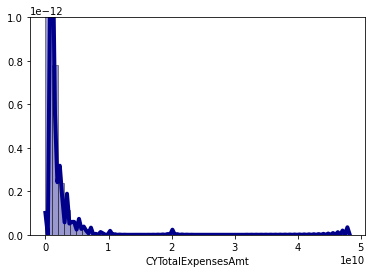

In [120]:
sns.distplot(df2015BERT['CYTotalExpensesAmt'], hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

# Separating dataframes by category 

In [10]:

df2015ArtsCulture = df2015BERT[df2015BERT['recommended'] == "I"]
df2015Education = df2015BERT[df2015BERT['recommended'] == "II"]
df2015Enviroment_Animals = df2015BERT[df2015BERT['recommended'] == "III"]
df2015Health = df2015BERT[df2015BERT['recommended'] == "IV"]
df2015HumanServices = df2015BERT[df2015BERT['recommended'] == "V"]
df2015International = df2015BERT[df2015BERT['recommended'] == "VI"]
df2015SocietalBenefit = df2015BERT[df2015BERT['recommended'] == "VII"]
df2015Religion = df2015BERT[df2015BERT['recommended'] == "VIII"]


# Logistic function that allows you to subset by category and remove outliers by percentile 
* It's broken into three parts. The first  includes the revenue diversification variable, and the second uses resource dependence

In [22]:
from sklearn import preprocessing
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


def logfunc(data, low, high):
    "data = the dataframe to be used"
    "low = low end of quintile"
    "high = high end of quintile"
    
    print("Before removing outliers","\n", data['CYTotalExpensesAmt'].describe(), "\n")
    df2015 = data[data['CYTotalExpensesAmt'].between(data['CYTotalExpensesAmt'].quantile(low), data['CYTotalExpensesAmt'].quantile(high))] # without outliers
    print("After removing outliers","\n", df2015['CYTotalExpensesAmt'].describe(),"\n")
    
    sns.distplot(df2015['CYTotalExpensesAmt'], hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
    
    
    
    logistic = df2015[['FormationYr',
                   'org_size',
                   'Ratio_Equity_Revenue',
                   'Ratio_AdminExp_Exp',
                   'Operating_Margin',
                   'Revenue_Concentration',
                   #'Ratio_ProgramExp_Rev',
                   'vulnerable'
                     ]]


    #with concentration 
    logistic = logistic.replace([np.inf, -np.inf], np.nan)
    logistic = logistic.fillna(0)
    logistic['vulnerable'] = logistic['vulnerable'].astype(float)
    X = logistic.loc[:, logistic.columns != 'vulnerable']
    X_colnames = X.columns
    X = pd.DataFrame(X, columns = X_colnames)
    y = logistic.loc[:, logistic.columns == 'vulnerable']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    y_train=y_train.values.reshape(-1,1)
    logit_model=sm.Logit(y_train,X_train)
    result=logit_model.fit(max_iter=10000)
    print("Using Revenue Concentration", "\n",result.summary2())
    
    #With Dependence 
    logistic = df2015[['FormationYr',
                        'org_size',
                        'Ratio_Equity_Revenue',
                        'Ratio_AdminExp_Exp',
                        'Operating_Margin',
                        'Dependence_Grants',
                        'Dependence_Campaigns',
                        'Dependence_Memberships',
                        'Dependence_Fundraising', 
                        'Dependence_ProgramServ',
                        'Dependence_Invest',
                        #'Ratio_ProgramExp_Rev',
                        'vulnerable'
                     ]]

    logistic = logistic.replace([np.inf, -np.inf], np.nan)
    logistic = logistic.fillna(0)
    logistic['vulnerable'] = logistic['vulnerable'].astype(float)
    X = logistic.loc[:, logistic.columns != 'vulnerable']
    X_colnames = X.columns
    X = pd.DataFrame(X, columns = X_colnames)
    y = logistic.loc[:, logistic.columns == 'vulnerable']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    y_train=y_train.values.reshape(-1,1)
    logit_model=sm.Logit(y_train,X_train)
    result=logit_model.fit(max_iter=10000)
    print("Using Resource Dependence", "\n",result.summary2())
    
    return

In [23]:
def logfunc_ps_decline(data, low, high):
    "data = the dataframe to be used"
    "low = low end of quintile"
    "high = high end of quintile"
    

    df2015 = data[data['CYTotalExpensesAmt'].between(data['CYTotalExpensesAmt'].quantile(low), data['CYTotalExpensesAmt'].quantile(high))] # without outliers
    
    
    logistic = df2015[['FormationYr',
                   'org_size',
                   'Ratio_Equity_Revenue',
                   'Ratio_AdminExp_Exp',
                   'Operating_Margin',
                   'Revenue_Concentration',
                   #'Ratio_ProgramExp_Rev',
                   'vulnerable_ps_decline'
                     ]]


    #with concentration 
    logistic = logistic.replace([np.inf, -np.inf], np.nan)
    logistic = logistic.fillna(0)
    logistic['vulnerable_ps_decline'] = logistic['vulnerable_ps_decline'].astype(float)
    X = logistic.loc[:, logistic.columns != 'vulnerable_ps_decline']
    X_colnames = X.columns
    X = pd.DataFrame(X, columns = X_colnames)
    y = logistic.loc[:, logistic.columns == 'vulnerable_ps_decline']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    y_train=y_train.values.reshape(-1,1)
    logit_model=sm.Logit(y_train,X_train)
    result=logit_model.fit(max_iter=10000)
    print("Using Revenue Concentration", "\n",result.summary2())
    
    #With Dependence 
    logistic = df2015[['FormationYr',
                        'org_size',
                        'Ratio_Equity_Revenue',
                        'Ratio_AdminExp_Exp',
                        'Operating_Margin',
                        'Dependence_Grants',
                        'Dependence_Campaigns',
                        'Dependence_Memberships',
                        'Dependence_Fundraising', 
                        'Dependence_ProgramServ',
                        'Dependence_Invest',
                        #'Ratio_ProgramExp_Rev',
                        'vulnerable_ps_decline'
                     ]]

    logistic = logistic.replace([np.inf, -np.inf], np.nan)
    logistic = logistic.fillna(0)
    logistic['vulnerable_ps_decline'] = logistic['vulnerable_ps_decline'].astype(float)
    X = logistic.loc[:, logistic.columns != 'vulnerable_ps_decline']
    X_colnames = X.columns
    X = pd.DataFrame(X, columns = X_colnames)
    y = logistic.loc[:, logistic.columns == 'vulnerable_ps_decline']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    y_train=y_train.values.reshape(-1,1)
    logit_model=sm.Logit(y_train,X_train)
    result=logit_model.fit(max_iter=10000)
    print("Using Resource Dependence", "\n",result.summary2())
    
    return

In [24]:
def logfunc_ps__total_decline(data, low, high):
    "data = the dataframe to be used"
    "low = low end of quintile"
    "high = high end of quintile"
    

    df2015 = data[data['CYTotalExpensesAmt'].between(data['CYTotalExpensesAmt'].quantile(low), data['CYTotalExpensesAmt'].quantile(high))] # without outliers
    
    
    logistic = df2015[['FormationYr',
                   'org_size',
                   'Ratio_Equity_Revenue',
                   'Ratio_AdminExp_Exp',
                   'Operating_Margin',
                   'Revenue_Concentration',
                   #'Ratio_ProgramExp_Rev',
                   'vulnerable_ps_total_decline'
                     ]]


    #with concentration 
    logistic = logistic.replace([np.inf, -np.inf], np.nan)
    logistic = logistic.fillna(0)
    logistic['vulnerable_ps_total_decline'] = logistic['vulnerable_ps_total_decline'].astype(float)
    X = logistic.loc[:, logistic.columns != 'vulnerable_ps_total_decline']
    X_colnames = X.columns
    X = pd.DataFrame(X, columns = X_colnames)
    y = logistic.loc[:, logistic.columns == 'vulnerable_ps_total_decline']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    y_train=y_train.values.reshape(-1,1)
    logit_model=sm.Logit(y_train,X_train)
    result=logit_model.fit(max_iter=10000)
    print("Using Revenue Concentration", "\n",result.summary2())
    
    #With Dependence 
    logistic = df2015[['FormationYr',
                        'org_size',
                        'Ratio_Equity_Revenue',
                        'Ratio_AdminExp_Exp',
                        'Operating_Margin',
                        'Dependence_Grants',
                        'Dependence_Campaigns',
                        'Dependence_Memberships',
                        'Dependence_Fundraising', 
                        'Dependence_ProgramServ',
                        'Dependence_Invest',
                        #'Ratio_ProgramExp_Rev',
                        'vulnerable_ps_total_decline'
                     ]]

    logistic = logistic.replace([np.inf, -np.inf], np.nan)
    logistic = logistic.fillna(0)
    logistic['vulnerable_ps_total_decline'] = logistic['vulnerable_ps_total_decline'].astype(float)
    X = logistic.loc[:, logistic.columns != 'vulnerable_ps_total_decline']
    X_colnames = X.columns
    X = pd.DataFrame(X, columns = X_colnames)
    y = logistic.loc[:, logistic.columns == 'vulnerable_ps_total_decline']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    y_train=y_train.values.reshape(-1,1)
    logit_model=sm.Logit(y_train,X_train)
    result=logit_model.fit(max_iter=10000)
    print("Using Resource Dependence", "\n",result.summary2())
    
    return

# Function to convert log odds to percentages 

In [25]:
#Converting logits to percentages
def convertlogit(logit):
    odds = np.exp(logit)
    prob = odds / (1+ odds)
    print(prob)
    return
    

In [26]:
convertlogit(5)

0.9933071490757152


# Arts and Culture

Before removing outliers 
 count    1.237700e+04
mean     2.052788e+06
std      1.599842e+07
min      0.000000e+00
25%      1.567640e+05
50%      3.385760e+05
75%      9.224160e+05
max      1.181631e+09
Name: CYTotalExpensesAmt, dtype: float64 

After removing outliers 
 count    1.175800e+04
mean     6.954123e+05
std      9.959463e+05
min      0.000000e+00
25%      1.471140e+05
50%      3.163830e+05
75%      7.731928e+05
max      6.072796e+06
Name: CYTotalExpensesAmt, dtype: float64 

Optimization terminated successfully.
         Current function value: 0.212938
         Iterations 18
Using Revenue Concentration 
                             Results: Logit
Model:                Logit              Pseudo R-squared:   0.006    
Dependent Variable:   y                  AIC:                3516.9537
Date:                 2020-11-19 14:18   BIC:                3559.0469
No. Observations:     8230               Log-Likelihood:     -1752.5  
Df Model:             5                  LL-Null:

C:\Users\tenis\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


                            Results: Logit
Model:                 Logit              Pseudo R-squared:   0.007    
Dependent Variable:    y                  AIC:                3523.3391
Date:                  2020-11-19 14:18   BIC:                3600.5100
No. Observations:      8230               Log-Likelihood:     -1750.7  
Df Model:              10                 LL-Null:            -1762.4  
Df Residuals:          8219               LLR p-value:        0.0094422
Converged:             1.0000             Scale:              1.0000   
No. Iterations:        8.0000                                          
-----------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
FormationYr            -0.0013   0.0000 -30.2407 0.0000 -0.0014 -0.0013
org_size               -0.0000   0.0005  -0.0570 0.9545 -0.0010  0.0009
Ratio_Equity_Revenue 

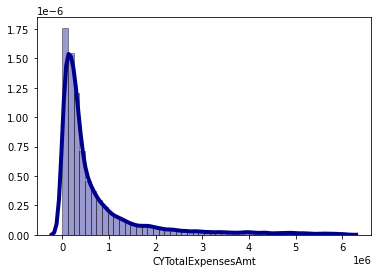

In [27]:
logfunc(df2015ArtsCulture, 0.00, .95)

In [29]:
logfunc_ps_decline(df2015ArtsCulture, 0.00, .95)

Optimization terminated successfully.
         Current function value: 0.199905
         Iterations 18
Using Revenue Concentration 
                             Results: Logit
Model:                 Logit             Pseudo R-squared:  0.012     
Dependent Variable:    y                 AIC:               3302.4359 
Date:                  2020-11-19 14:19  BIC:               3344.5292 
No. Observations:      8230              Log-Likelihood:    -1645.2   
Df Model:              5                 LL-Null:           -1664.6   
Df Residuals:          8224              LLR p-value:       2.7564e-07
Converged:             1.0000            Scale:             1.0000    
No. Iterations:        18.0000                                        
----------------------------------------------------------------------
                       Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------
FormationYr           -0.0013   0.0000 -28.

In [30]:
logfunc_ps__total_decline(df2015ArtsCulture, 0.00, .95)

Optimization terminated successfully.
         Current function value: 0.259244
         Iterations 17
Using Revenue Concentration 
                             Results: Logit
Model:                 Logit             Pseudo R-squared:  0.013     
Dependent Variable:    y                 AIC:               4279.1573 
Date:                  2020-11-19 14:19  BIC:               4321.2505 
No. Observations:      8230              Log-Likelihood:    -2133.6   
Df Model:              5                 LL-Null:           -2161.4   
Df Residuals:          8224              LLR p-value:       9.3020e-11
Converged:             1.0000            Scale:             1.0000    
No. Iterations:        17.0000                                        
----------------------------------------------------------------------
                       Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------
FormationYr           -0.0012   0.0000 -32.

# Education 

Before removing outliers 
 count    1.854200e+04
mean     8.512450e+06
std      1.007930e+08
min      0.000000e+00
25%      1.962235e+05
50%      5.484515e+05
75%      2.343110e+06
max      5.910464e+09
Name: CYTotalExpensesAmt, dtype: float64 

After removing outliers 
 count    1.557400e+04
mean     8.864261e+05
std      1.106237e+06
min      3.461000e+03
25%      1.690315e+05
50%      4.022900e+05
75%      1.137992e+06
max      5.060494e+06
Name: CYTotalExpensesAmt, dtype: float64 

Optimization terminated successfully.
         Current function value: 0.208591
         Iterations 16
Using Revenue Concentration 
                             Results: Logit
Model:                 Logit             Pseudo R-squared:  0.005     
Dependent Variable:    y                 AIC:               4561.7077 
Date:                  2020-11-12 12:47  BIC:               4612.7840 
No. Observations:      10901             Log-Likelihood:    -2273.9   
Df Model:              6                 LL-Null:

C:\Users\tenis\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



Optimization terminated successfully.
         Current function value: 0.208379
         Iterations 11
Using Resource Dependence 
                             Results: Logit
Model:                 Logit              Pseudo R-squared:   0.006    
Dependent Variable:    y                  AIC:                4567.0756
Date:                  2020-11-12 12:47   BIC:                4654.6349
No. Observations:      10901              Log-Likelihood:     -2271.5  
Df Model:              11                 LL-Null:            -2285.9  
Df Residuals:          10889              LLR p-value:        0.0025506
Converged:             1.0000             Scale:              1.0000   
No. Iterations:        11.0000                                         
-----------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
FormationYr            -0.0014   

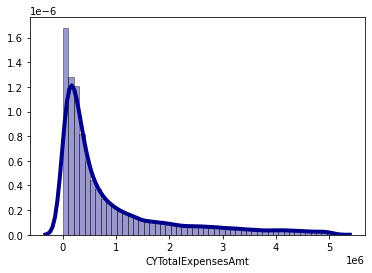

In [177]:
logfunc(df2015Education,0.01, .85)

In [192]:
logfunc_ps_decline(df2015Education,0.01, .85)

Optimization terminated successfully.
         Current function value: 0.208620
         Iterations 19
Using Revenue Concentration 
                             Results: Logit
Model:                 Logit             Pseudo R-squared:  0.005     
Dependent Variable:    y                 AIC:               4562.3297 
Date:                  2020-11-12 13:19  BIC:               4613.4060 
No. Observations:      10901             Log-Likelihood:    -2274.2   
Df Model:              6                 LL-Null:           -2285.9   
Df Residuals:          10894             LLR p-value:       0.00066763
Converged:             1.0000            Scale:             1.0000    
No. Iterations:        19.0000                                        
----------------------------------------------------------------------
                       Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------
FormationYr           -0.0014   0.0000 -27.

# Environment and Animals

Before removing outliers 
 count    6.557000e+03
mean     2.183481e+06
std      1.589077e+07
min      0.000000e+00
25%      1.718820e+05
50%      3.647270e+05
75%      9.732940e+05
max      8.102836e+08
Name: CYTotalExpensesAmt, dtype: float64 

After removing outliers 
 count    5.835000e+03
mean     5.379765e+05
std      5.740958e+05
min      5.500000e+03
25%      1.577765e+05
50%      3.231320e+05
75%      6.945865e+05
max      2.765632e+06
Name: CYTotalExpensesAmt, dtype: float64 

Optimization terminated successfully.
         Current function value: 0.202147
         Iterations 11
Using Revenue Concentration 
                             Results: Logit
Model:                Logit              Pseudo R-squared:   0.006    
Dependent Variable:   y                  AIC:                1665.1381
Date:                 2020-11-12 12:18   BIC:                1709.3419
No. Observations:     4084               Log-Likelihood:     -825.57  
Df Model:             6                  LL-Null:

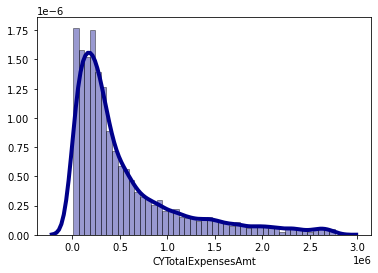

In [134]:
logfunc(df2015Enviroment_Animals, 0.01, .90)

In [193]:
logfunc_ps_decline(df2015Enviroment_Animals, 0.01, .90)

Optimization terminated successfully.
         Current function value: 0.175706
         Iterations 16
Using Revenue Concentration 
                            Results: Logit
Model:                Logit             Pseudo R-squared:  0.019     
Dependent Variable:   y                 AIC:               1449.1638 
Date:                 2020-11-12 13:20  BIC:               1493.3677 
No. Observations:     4084              Log-Likelihood:    -717.58   
Df Model:             6                 LL-Null:           -731.75   
Df Residuals:         4077              LLR p-value:       8.1490e-05
Converged:            1.0000            Scale:             1.0000    
No. Iterations:       16.0000                                        
---------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------
FormationYr           -0.0016   0.0002 -9.5522 0.0000 -

# Health Organizations

Before removing outliers 
 count    1.962600e+04
mean     3.998758e+07
std      4.410133e+08
min     -1.475955e+06
25%      2.848770e+05
50%      1.020044e+06
75%      6.452392e+06
max      4.825271e+10
Name: CYTotalExpensesAmt, dtype: float64 

After removing outliers 
 count    1.648500e+04
mean     2.334977e+06
std      3.632472e+06
min      5.181000e+03
25%      2.499600e+05
50%      6.896620e+05
75%      2.531080e+06
max      1.762728e+07
Name: CYTotalExpensesAmt, dtype: float64 

Optimization terminated successfully.
         Current function value: 0.229316
         Iterations 7
Using Revenue Concentration 
                             Results: Logit
Model:                Logit              Pseudo R-squared:   0.003    
Dependent Variable:   y                  AIC:                5306.1467
Date:                 2020-11-12 13:21   BIC:                5357.6211
No. Observations:     11539              Log-Likelihood:     -2646.1  
Df Model:             6                  LL-Null: 

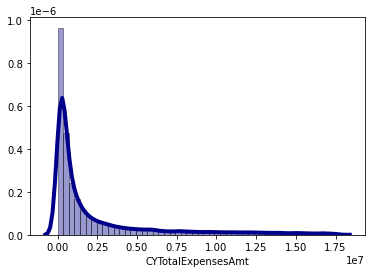

In [194]:
logfunc(df2015Health, 0.01, .85)

In [195]:
logfunc_ps_decline(df2015Health, 0.01, .85)

Optimization terminated successfully.
         Current function value: 0.254574
         Iterations 7
Using Revenue Concentration 
                             Results: Logit
Model:                Logit              Pseudo R-squared:   0.001    
Dependent Variable:   y                  AIC:                5889.0635
Date:                 2020-11-12 13:21   BIC:                5940.5379
No. Observations:     11539              Log-Likelihood:     -2937.5  
Df Model:             6                  LL-Null:            -2940.4  
Df Residuals:         11532              LLR p-value:        0.46436  
Converged:            1.0000             Scale:              1.0000   
No. Iterations:       7.0000                                          
----------------------------------------------------------------------
                       Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------
FormationYr           -0.0013   0.0000 -45.8

# Human Services

Before removing outliers 
 count    5.794700e+04
mean     2.995848e+06
std      2.430238e+07
min     -2.497300e+04
25%      1.999005e+05
50%      4.634330e+05
75%      1.477794e+06
max      2.679604e+09
Name: CYTotalExpensesAmt, dtype: float64 

After removing outliers 
 count    4.635700e+04
mean     4.986850e+05
std      4.689071e+05
min     -2.497300e+04
25%      1.634470e+05
50%      3.274260e+05
75%      6.893980e+05
max      2.050721e+06
Name: CYTotalExpensesAmt, dtype: float64 

Optimization terminated successfully.
         Current function value: 0.217141
         Iterations 9
Using Revenue Concentration 
                             Results: Logit
Model:                 Logit             Pseudo R-squared:  0.002     
Dependent Variable:    y                 AIC:               14104.0103
Date:                  2020-11-19 14:24  BIC:               14154.3348
No. Observations:      32449             Log-Likelihood:    -7046.0   
Df Model:              5                 LL-Null: 

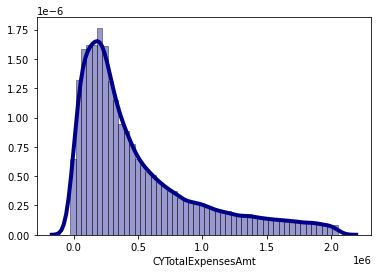

In [41]:
logfunc(df2015HumanServices,0.00, .8)

In [38]:
logfunc_ps_decline(df2015HumanServices,0.00, .85)

Optimization terminated successfully.
         Current function value: 0.203886
         Iterations 9
Using Revenue Concentration 
                             Results: Logit
Model:                 Logit             Pseudo R-squared:  0.002     
Dependent Variable:    y                 AIC:               14071.1972
Date:                  2020-11-19 14:21  BIC:               14121.8857
No. Observations:      34478             Log-Likelihood:    -7029.6   
Df Model:              5                 LL-Null:           -7043.5   
Df Residuals:          34472             LLR p-value:       3.8847e-05
Converged:             1.0000            Scale:             1.0000    
No. Iterations:        9.0000                                         
----------------------------------------------------------------------
                       Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------
FormationYr           -0.0014   0.0000 -74.4

# International

Before removing outliers 
 count    2.699000e+03
mean     7.332127e+06
std      4.738024e+07
min      0.000000e+00
25%      2.229880e+05
50%      4.923390e+05
75%      1.464932e+06
max      9.820869e+08
Name: CYTotalExpensesAmt, dtype: float64 

After removing outliers 
 count    2.294000e+03
mean     6.339998e+05
std      6.615495e+05
min      0.000000e+00
25%      1.996015e+05
50%      3.933630e+05
75%      8.077055e+05
max      3.192422e+06
Name: CYTotalExpensesAmt, dtype: float64 

Optimization terminated successfully.
         Current function value: 0.180287
         Iterations 16
Using Revenue Concentration 
                             Results: Logit
Model:                 Logit              Pseudo R-squared:   0.005   
Dependent Variable:    y                  AIC:                592.7219
Date:                  2020-11-12 12:23   BIC:                630.3880
No. Observations:      1605               Log-Likelihood:     -289.36 
Df Model:              6                  LL-Null

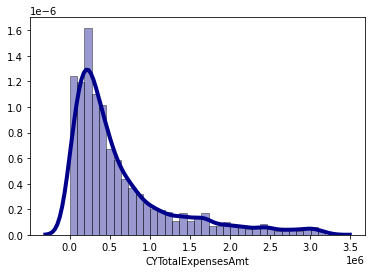

In [146]:
logfunc(df2015International,0.00, .85)

In [198]:
logfunc_ps_decline(df2015International,0.00, .85)

Optimization terminated successfully.
         Current function value: 0.264530
         Iterations 21
Using Revenue Concentration 
                            Results: Logit
Model:                Logit              Pseudo R-squared:   0.011   
Dependent Variable:   y                  AIC:                863.1411
Date:                 2020-11-12 13:23   BIC:                900.8072
No. Observations:     1605               Log-Likelihood:     -424.57 
Df Model:             6                  LL-Null:            -429.12 
Df Residuals:         1598               LLR p-value:        0.16858 
Converged:            1.0000             Scale:              1.0000  
No. Iterations:       21.0000                                        
---------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------
FormationYr           -0.0012   0.0002 -7.4269 0.0000 -

# Societal Benefit

Before removing outliers 
 count    2.766300e+04
mean     5.506670e+06
std      4.855524e+07
min     -4.179830e+05
25%      1.804475e+05
50%      4.418230e+05
75%      1.518964e+06
max      4.910675e+09
Name: CYTotalExpensesAmt, dtype: float64 

After removing outliers 
 count    2.185300e+04
mean     4.937125e+05
std      4.862703e+05
min      2.061000e+03
25%      1.467200e+05
50%      3.132550e+05
75%      6.749300e+05
max      2.146291e+06
Name: CYTotalExpensesAmt, dtype: float64 

Optimization terminated successfully.
         Current function value: 0.186121
         Iterations 14
Using Revenue Concentration 
                             Results: Logit
Model:                Logit              Pseudo R-squared:   0.001    
Dependent Variable:   y                  AIC:                5706.1990
Date:                 2020-11-19 14:25   BIC:                5752.0115
No. Observations:     15297              Log-Likelihood:     -2847.1  
Df Model:             5                  LL-Null:

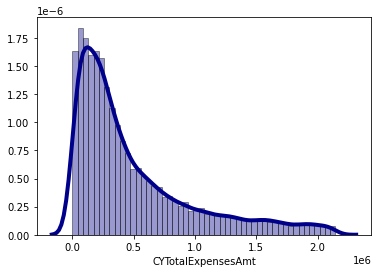

In [46]:
logfunc(df2015SocietalBenefit, 0.01, .8)

In [199]:
logfunc_ps_decline(df2015SocietalBenefit, 0.00, .97)

Optimization terminated successfully.
         Current function value: 0.197785
         Iterations 14
Using Revenue Concentration 
                             Results: Logit
Model:                Logit              Pseudo R-squared:   0.000    
Dependent Variable:   y                  AIC:                7444.0078
Date:                 2020-11-12 13:23   BIC:                7498.8927
No. Observations:     18783              Log-Likelihood:     -3715.0  
Df Model:             6                  LL-Null:            -3716.5  
Df Residuals:         18776              LLR p-value:        0.81414  
Converged:            1.0000             Scale:              1.0000   
No. Iterations:       14.0000                                         
----------------------------------------------------------------------
                       Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------
FormationYr           -0.0015   0.0000 -64.

# Religion 

Before removing outliers 
 count    6.515000e+03
mean     2.684316e+06
std      3.139204e+07
min      0.000000e+00
25%      1.496825e+05
50%      3.271080e+05
75%      8.366620e+05
max      1.483659e+09
Name: CYTotalExpensesAmt, dtype: float64 

After removing outliers 
 count    6.123000e+03
mean     6.179580e+05
std      8.246331e+05
min      3.000000e+03
25%      1.450680e+05
50%      3.059030e+05
75%      7.258080e+05
max      5.064179e+06
Name: CYTotalExpensesAmt, dtype: float64 

Optimization terminated successfully.
         Current function value: 0.213319
         Iterations 11
Using Revenue Concentration 
                             Results: Logit
Model:                Logit              Pseudo R-squared:   0.008    
Dependent Variable:   y                  AIC:                1842.5718
Date:                 2020-11-12 12:25   BIC:                1887.1135
No. Observations:     4286               Log-Likelihood:     -914.29  
Df Model:             6                  LL-Null:

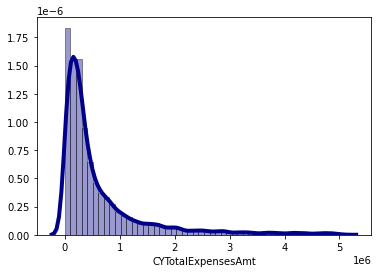

In [154]:
logfunc(df2015Religion,0.01, .95)

In [200]:
logfunc_ps_decline(df2015Religion,0.01, .95)

Optimization terminated successfully.
         Current function value: 0.248531
         Iterations 12
Using Revenue Concentration 
                             Results: Logit
Model:                 Logit             Pseudo R-squared:  0.011     
Dependent Variable:    y                 AIC:               2144.4060 
Date:                  2020-11-12 13:25  BIC:               2188.9477 
No. Observations:      4286              Log-Likelihood:    -1065.2   
Df Model:              6                 LL-Null:           -1076.7   
Df Residuals:          4279              LLR p-value:       0.00081959
Converged:             1.0000            Scale:             1.0000    
No. Iterations:        12.0000                                        
----------------------------------------------------------------------
                       Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------
FormationYr           -0.0012   0.0001 -21.

In [202]:
NTEE_Code = pd.get_dummies(df2015BERT.recommended, prefix='NTEE_Code')
df2015_all_categories= pd.concat([df2015BERT.reset_index(drop=True), NTEE_Code], axis=1, ignore_index=False)

Before removing outliers 
 count    1.576080e+05
mean     9.147660e+06
std      1.653444e+08
min     -2.209473e+06
25%      1.929198e+05
50%      4.724060e+05
75%      1.700779e+06
max      4.825271e+10
Name: CYTotalExpensesAmt, dtype: float64 

After removing outliers 
 count    1.402700e+05
mean     9.686189e+05
std      1.381817e+06
min      3.857000e+03
25%      1.791658e+05
50%      3.974740e+05
75%      1.083456e+06
max      7.461774e+06
Name: CYTotalExpensesAmt, dtype: float64 

Optimization terminated successfully.
         Current function value: 0.212348
         Iterations 9
                            Results: Logit
Model:                 Logit             Pseudo R-squared:  0.002     
Dependent Variable:    y                 AIC:               41732.4856
Date:                  2020-11-12 12:31  BIC:               41884.4000
No. Observations:      98189             Log-Likelihood:    -20850.   
Df Model:              15                LL-Null:           -20886.   
Df Residu

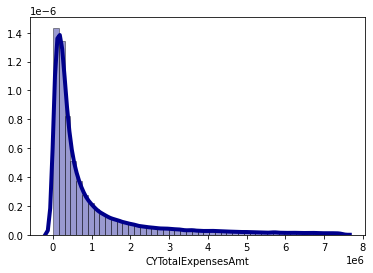

In [165]:
from sklearn import preprocessing
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

print("Before removing outliers","\n", df2015_all_categories['CYTotalExpensesAmt'].describe(), "\n")
df2015_full = df2015_all_categories[df2015_all_categories['CYTotalExpensesAmt'].between(df2015_all_categories['CYTotalExpensesAmt'].quantile(.01), df2015_all_categories['CYTotalExpensesAmt'].quantile(.9))] # without outliers
print("After removing outliers","\n", df2015_full['CYTotalExpensesAmt'].describe(),"\n")
    
sns.distplot(df2015_full['CYTotalExpensesAmt'], hist=True, kde=True, 
         color = 'darkblue', 
         hist_kws={'edgecolor':'black'},
         kde_kws={'linewidth': 4})

logistic = df2015_full[['FormationYr',
               'CYTotalExpensesAmt',
               'Ratio_Equity_Revenue',
               'Ratio_AdminExp_Exp',
               'Operating_Margin',
               'Revenue_Concentration',
               #'Ratio_ProgramExp_Rev',
               'vulnerable',
               'NTEE_Code_I',
               'NTEE_Code_II',
               'NTEE_Code_III',
               'NTEE_Code_IV',
               'NTEE_Code_IX',
               'NTEE_Code_V',
               'NTEE_Code_VI',
               'NTEE_Code_VII',
               'NTEE_Code_VIII'
                 ]]

#'Dependence_Grants',
#'Dependence_Campaigns',
#'Dependence_Memberships',
#'Dependence_Fundraising', 
#'Dependence_ProgramServ',
#'Dependence_Invest'

#Apparently no trust in this dataset. 
logistic = logistic.replace([np.inf, -np.inf], np.nan)
logistic = logistic.fillna(0)



logistic['vulnerable'] = logistic['vulnerable'].astype(float)



X = logistic.loc[:, logistic.columns != 'vulnerable']
X_colnames = X.columns

#normalizeing
#X = preprocessing.normalize(X)
X = pd.DataFrame(X, columns = X_colnames)
y = logistic.loc[:, logistic.columns == 'vulnerable']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


y_train=y_train.values.reshape(-1,1)

logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit(max_iter=500)
print(result.summary2())

In [204]:

df2015_full = df2015_all_categories[df2015_all_categories['CYTotalExpensesAmt'].between(df2015_all_categories['CYTotalExpensesAmt'].quantile(.01), df2015_all_categories['CYTotalExpensesAmt'].quantile(.9))] # without outliers

logistic = df2015_full[['FormationYr',
               'CYTotalExpensesAmt',
               'Ratio_Equity_Revenue',
               'Ratio_AdminExp_Exp',
               'Operating_Margin',
               'Revenue_Concentration',
               #'Ratio_ProgramExp_Rev',
               'vulnerable_ps_decline',
               'NTEE_Code_I',
               'NTEE_Code_II',
               'NTEE_Code_III',
               'NTEE_Code_IV',
               'NTEE_Code_IX',
               'NTEE_Code_V',
               'NTEE_Code_VI',
               'NTEE_Code_VII',
               'NTEE_Code_VIII'
                 ]]

#'Dependence_Grants',
#'Dependence_Campaigns',
#'Dependence_Memberships',
#'Dependence_Fundraising', 
#'Dependence_ProgramServ',
#'Dependence_Invest'

#Apparently no trust in this dataset. 
logistic = logistic.replace([np.inf, -np.inf], np.nan)
logistic = logistic.fillna(0)



logistic['vulnerable_ps_decline'] = logistic['vulnerable_ps_decline'].astype(float)



X = logistic.loc[:, logistic.columns != 'vulnerable_ps_decline']
X_colnames = X.columns

#normalizeing
#X = preprocessing.normalize(X)
X = pd.DataFrame(X, columns = X_colnames)
y = logistic.loc[:, logistic.columns == 'vulnerable_ps_decline']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


y_train=y_train.values.reshape(-1,1)

logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit(max_iter=500)
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.210391
         Iterations 9
                            Results: Logit
Model:                 Logit             Pseudo R-squared:  0.002     
Dependent Variable:    y                 AIC:               41348.0968
Date:                  2020-11-12 13:27  BIC:               41500.0112
No. Observations:      98189             Log-Likelihood:    -20658.   
Df Model:              15                LL-Null:           -20692.   
Df Residuals:          98173             LLR p-value:       1.2194e-08
Converged:             1.0000            Scale:             1.0000    
No. Iterations:        9.0000                                         
----------------------------------------------------------------------
                       Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------
FormationYr           -0.0013   0.0000 -47.2018 0.0000 -0.0014 -0.0013
CYT